In [63]:
import tensorflow as tf
import os
import numpy as np
import random

In [64]:
print("Num GPus Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPus Available:  0


In [65]:
SEED = 123456
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [66]:
from tensorflow.keras.datasets import fashion_mnist

In [67]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28) 
assert y_train.shape == (60000,) 
assert y_test.shape == (10000,)

In [68]:
from matplotlib import pyplot as plt

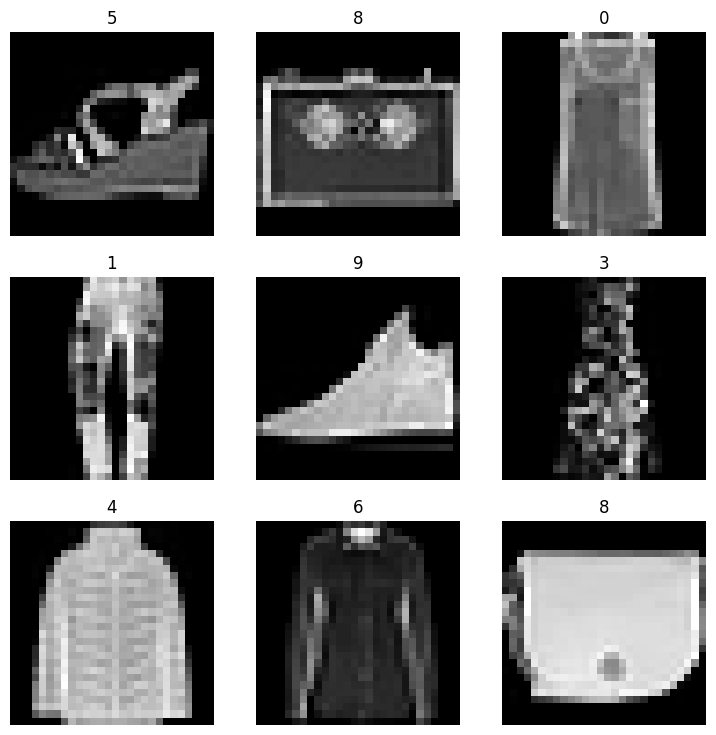

In [69]:
plt.figure(figsize=(9,9))

rndSamples = np.random.choice(60000, 9)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[rndSamples[i]], cmap='gray')
    plt.title(y_train[rndSamples[i]])
    plt.axis('off')
plt.show()

In [70]:
dataset = np.concatenate([x_train, x_test], axis=0)
dataset = np.expand_dims(dataset, axis=-1).astype('float32') / 255.0

In [71]:
from tensorflow import keras
from tensorflow.keras import layers

class Sampling(layers.Layer):
    def call(self, inputs):
        """
        Amostra uma distribuição normal com base nos parâmetros de média e log-variância fornecidos.

        Args:
            inputs: Uma tupla contendo os tensores de média (z_mean) e log-variância (z_log_var).

        Returns:
            Um tensor amostrado da distribuição normal com base nos parâmetros de entrada.
        """
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [72]:
def buildEncoder(latentDim, encoderInputs):
    # Cria uma sequência de camadas do modelo do encoder
    l1 = keras.models.Sequential([
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', strides=2, padding='same', input_shape=(28, 28, 1)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', strides=2, padding='same'),
        layers.Flatten(),
        layers.Dense(256, activation='relu')    
    ])
    
    # Aplica as camadas do modelo do encoder nas entradas do encoder
    x = l1(encoderInputs)
    
    # Calcula a média e o logaritmo da variância do vetor latente
    zMean = layers.Dense(latentDim, name='z_mean')(x)
    zLogVar = layers.Dense(latentDim, name='z_log_var')(x)
    
    # Amostra o vetor latente usando a média e o logaritmo da variância
    z = Sampling()([zMean, zLogVar])
    
    # Retorna o modelo do encoder
    return keras.Model(encoderInputs, [zMean, zLogVar, z], name='encoder')

# Define as entradas do encoder
encoderInputs = keras.Input(shape=(28, 28, 1))

# Constrói o modelo do encoder com dimensão latente igual a 2
encoder = buildEncoder(2, encoderInputs)

# Exibe um resumo do modelo do encoder
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 sequential_5 (Sequential)   (None, 256)                  878144    ['input_8[0][0]']             
                                                                                                  
 z_mean (Dense)              (None, 2)                    514       ['sequential_5[0][0]']        
                                                                                                  
 z_log_var (Dense)           (None, 2)                    514       ['sequential_5[0][0]']        
                                                                                            

In [73]:
def buildDecoder(latenInputs):
    # Cria uma sequência de camadas do modelo do decoder
    l1 = keras.models.Sequential([
        layers.Dense(7*7*64, activation='relu', input_shape=(2,)),
        layers.Reshape((7, 7, 64)),
        layers.Conv2DTranspose(64, kernel_size=(3, 3), activation='relu', strides=2, padding='same'),
        layers.Conv2DTranspose(128, kernel_size=(3, 3), activation='relu', strides=2, padding='same'),
        layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
    ])
    
    # Aplica as camadas do modelo do decoder nas entradas do decoder
    x = l1(latenInputs)
    
    # Retorna o modelo do decoder
    return keras.Model(latenInputs, x, name='decoder')

latentInputs = keras.Input(shape=(2,))
decoder = buildDecoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 2)]               0         
                                                                 
 sequential_6 (Sequential)   (None, 28, 28, 1)         121345    
                                                                 
Total params: 121345 (474.00 KB)
Trainable params: 121345 (474.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
def recontructionLoss(data, reconstructded):
    return tf.reduce_mean(
        tf.reduce_sum(
            keras.losses.binary_crossentropy(data, reconstructded), axis=(1, 2)
        )
    )

In [75]:
def KlDivergenceLoss(zMean, zLogVar):
    return -0.5 * tf.reduce_mean(
        tf.reduce_sum(1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar), axis=1)
    )

In [76]:
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
    reconstructionLoss = recontructionLoss(data, reconstructed)
    klDivergenceLoss = KlDivergenceLoss(zMean, zLogVar)
    return reconstructionLoss + klDivergenceLoss

In [77]:
from keras.metrics import Mean

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        """
        Inicializa a classe VAE.

        Parâmetros:
        - encoder: O modelo do codificador.
        - decoder: O modelo do decodificador.
        - **kwargs: Argumentos adicionais a serem passados para a classe pai.

        """
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.totalLossTracker = Mean(name='total_loss')
        self.ceLossTracker = Mean(name='ce_loss')
        self.klLossTracker = Mean(name='kl_loss')

    @property
    def metrics(self):
        """
        Retorna as métricas utilizadas para avaliar o modelo.

        Retorna:
        - Uma lista contendo as métricas utilizadas.

        """
        return [
            self.totalLossTracker,
            self.ceLossTracker,
            self.klLossTracker
        ]
    
    def train_step(self, data):
        """
        Executa um passo de treinamento do modelo.

        Parâmetros:
        - data: Os dados de entrada para o treinamento.

        Retorna:
        - Um dicionário contendo as métricas calculadas durante o treinamento.

        """
        with tf.GradientTape() as tape:
            zMean, zLogVar, z = self.encoder(data)
            reconstruction = self.decoder(z)
            ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)
        
        grads = tape.gradient(totalLoss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.totalLossTracker.update_state(totalLoss)
        self.ceLossTracker.update_state(ceLoss)
        self.klLossTracker.update_state(klLoss)

        return {
            'total_loss': self.totalLossTracker.result(),
            'ce_loss': self.ceLossTracker.result(),
            'kl_loss': self.klLossTracker.result()
        }

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
hostory = vae.fit(dataset, epochs=30, batch_size=128)